In [1]:
from main import main
from PDconfig import ZonaP
from frames.archivosDF import *

main()
ruta_barrios = './DataFrames/MeLi/barrios.csv'
ruta_ciudades = './DataFrames/MeLi/ciudades.csv'
df = abrirDF(ZonaP)

In [11]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# ELIMINAR TIPO PROP INSERVIBLES
filt = df['tipoPropiedad'] == 'PH'
df.loc[filt, 'tipoPropiedad'] = "DEPARTAMENTO"

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS"]


13172

In [39]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.005), 
                                          inmuebles["terrenoTotal"].quantile(0.999))
filtro_TT = inmuebles["terrenoEdificado"].between(inmuebles["terrenoEdificado"].quantile(0.005), 
                                          inmuebles["terrenoEdificado"].quantile(0.999))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.005), 
                                          inmuebles["precioUSD"].quantile(0.999))
inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

"""# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], format='%d-%m-%Y')
# Filter the DataFrame to include only rows from the year 2023
inmuebles_filt = inmuebles_filt.loc[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]"""

"# Convert the 'fechaUltimaActualizacion' column to datetime objects\ninmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], format='%d-%m-%Y')\n# Filter the DataFrame to include only rows from the year 2023\ninmuebles_filt = inmuebles_filt.loc[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]"

In [40]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

C:\Users\benja\AppData\Local\Temp\ipykernel_7692\3911280188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
C:\Users\benja\AppData\Local\Temp\ipykernel_7692\3911280188.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']


62


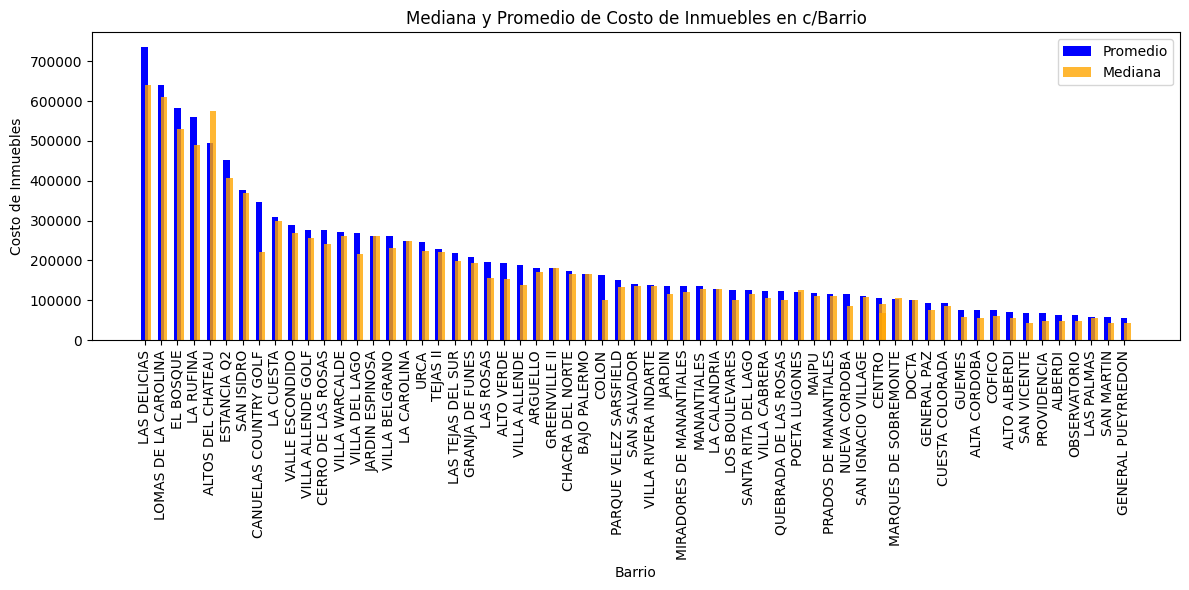

In [41]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean()
precio_m2_total_median = grouped_data['precio_m2_total'].median()
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean()
precio_m2_edif_median = grouped_data['precio_m2_edif'].median()

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


C:\Users\benja\AppData\Local\Temp\ipykernel_7692\1982482442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
C:\Users\benja\AppData\Local\Temp\ipykernel_7692\1982482442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']


28


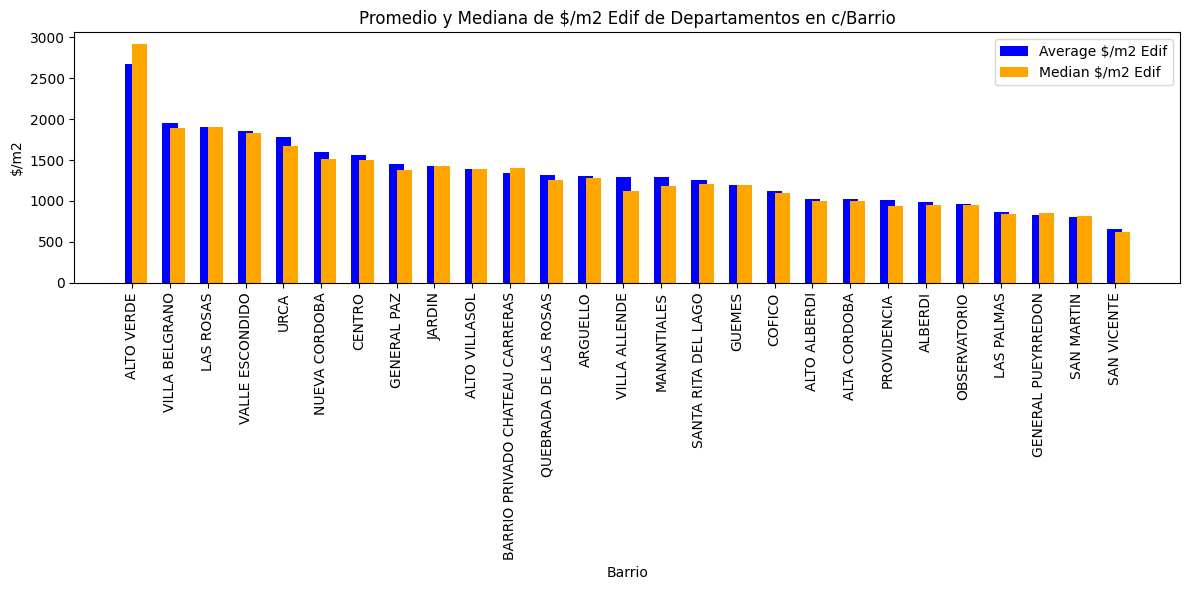

In [47]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 Edif de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
filt = (inmuebles_filt['barrio'] == 'ALTO VERDE') & (inmuebles_filt['tipoPropiedad'] == 'DEPARTAMENTO')
#departamento_df[['barrio', 'Precio m2 Edif Mean', 'Precio m2 Edif Median']]
inmuebles_filt.loc[filt, ['precioUSD', 'terrenoTotal']].sort_values(by= 'terrenoTotal', ascending=True).head(10)

,precioUSD,terrenoTotal
507,120000,1.0
7478,153000,42.0
14684,175000,60.0
6467,45000,63.0
16370,250000,70.0
13520,300000,81.0
1083,310000,81.0
9739,280000,81.0
12648,230000,87.0
9326,280000,90.0


40


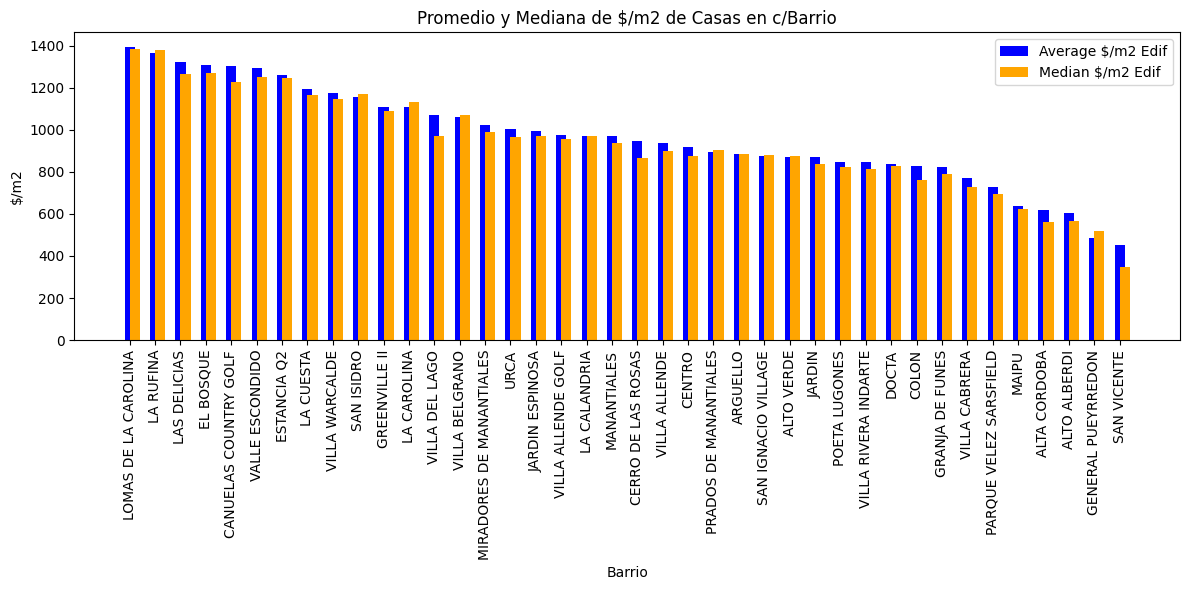

In [48]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
casas_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
casas_df = casas_df[(casas_df['tipoPropiedad'] == 'CASA') & (casas_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = casas_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, casas_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, casas_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
casas_df['prom'] = (casas_df['Precio m2 Edif Mean'] + casas_df['Precio m2 Edif Median'])/2
rank = casas_df[['barrio', 'prom']].head(20).reset_index()
rank

,index,barrio,prom
0,243,ALTOS DEL CHATEAU,1418.476558
1,861,LA CASCADA COUNTRY GOLF,1373.093497
2,896,LOMAS DE LA CAROLINA,1388.822765
3,1582,LA RUFINA,1371.630446
4,897,LOMAS DE LOS CAROLINOS,1323.956561
5,880,LAS DELICIAS,1293.696629
6,733,EL BOSQUE,1288.241178
7,317,CANUELAS COUNTRY GOLF,1263.463515
8,1205,VALLE ESCONDIDO,1272.839086
9,2459,CHACRAS DE LA VILLA,1206.630224


In [49]:
filt = inmuebles_filt["coordX"].notna() & (inmuebles_filt['tipoPropiedad'] == 'DEPARTAMENTO')
ubicados = inmuebles_filt.loc[filt]

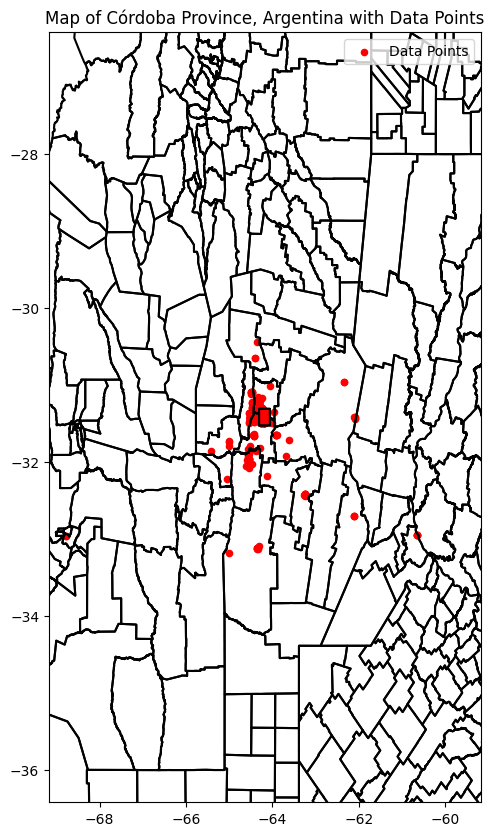

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'ubicados' and has columns 'coordX' (latitude) and 'coordY' (longitude)
# Replace these values with the actual column names from your DataFrame
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']

# Calculate the mean latitude and longitude to center the map
mean_latitude = latitudes.mean()
mean_longitude = longitudes.mean()

# Read the shapefile of Córdoba province
cordoba_shapefile = './utils/maps/departamento.shp'
cordoba_province = gpd.read_file(cordoba_shapefile)

# Create a plot with the province boundary and center the map on the mean position
fig, ax = plt.subplots(figsize=(10, 10))
cordoba_province.boundary.plot(ax=ax, color='black')
ax.scatter(longitudes, latitudes, color='red', s=20, label='Data Points')

# Set the extent of the map to zoom out a bit around the mean position
map_padding = 5  # Increase the padding for more zoom-out effect
ax.set_xlim(mean_longitude - map_padding, mean_longitude + map_padding)
ax.set_ylim(mean_latitude - map_padding, mean_latitude + map_padding)

# Add a title and legend
ax.set_title('Map of Córdoba Province, Argentina with Data Points')
ax.legend()

# Show the plot
plt.show()

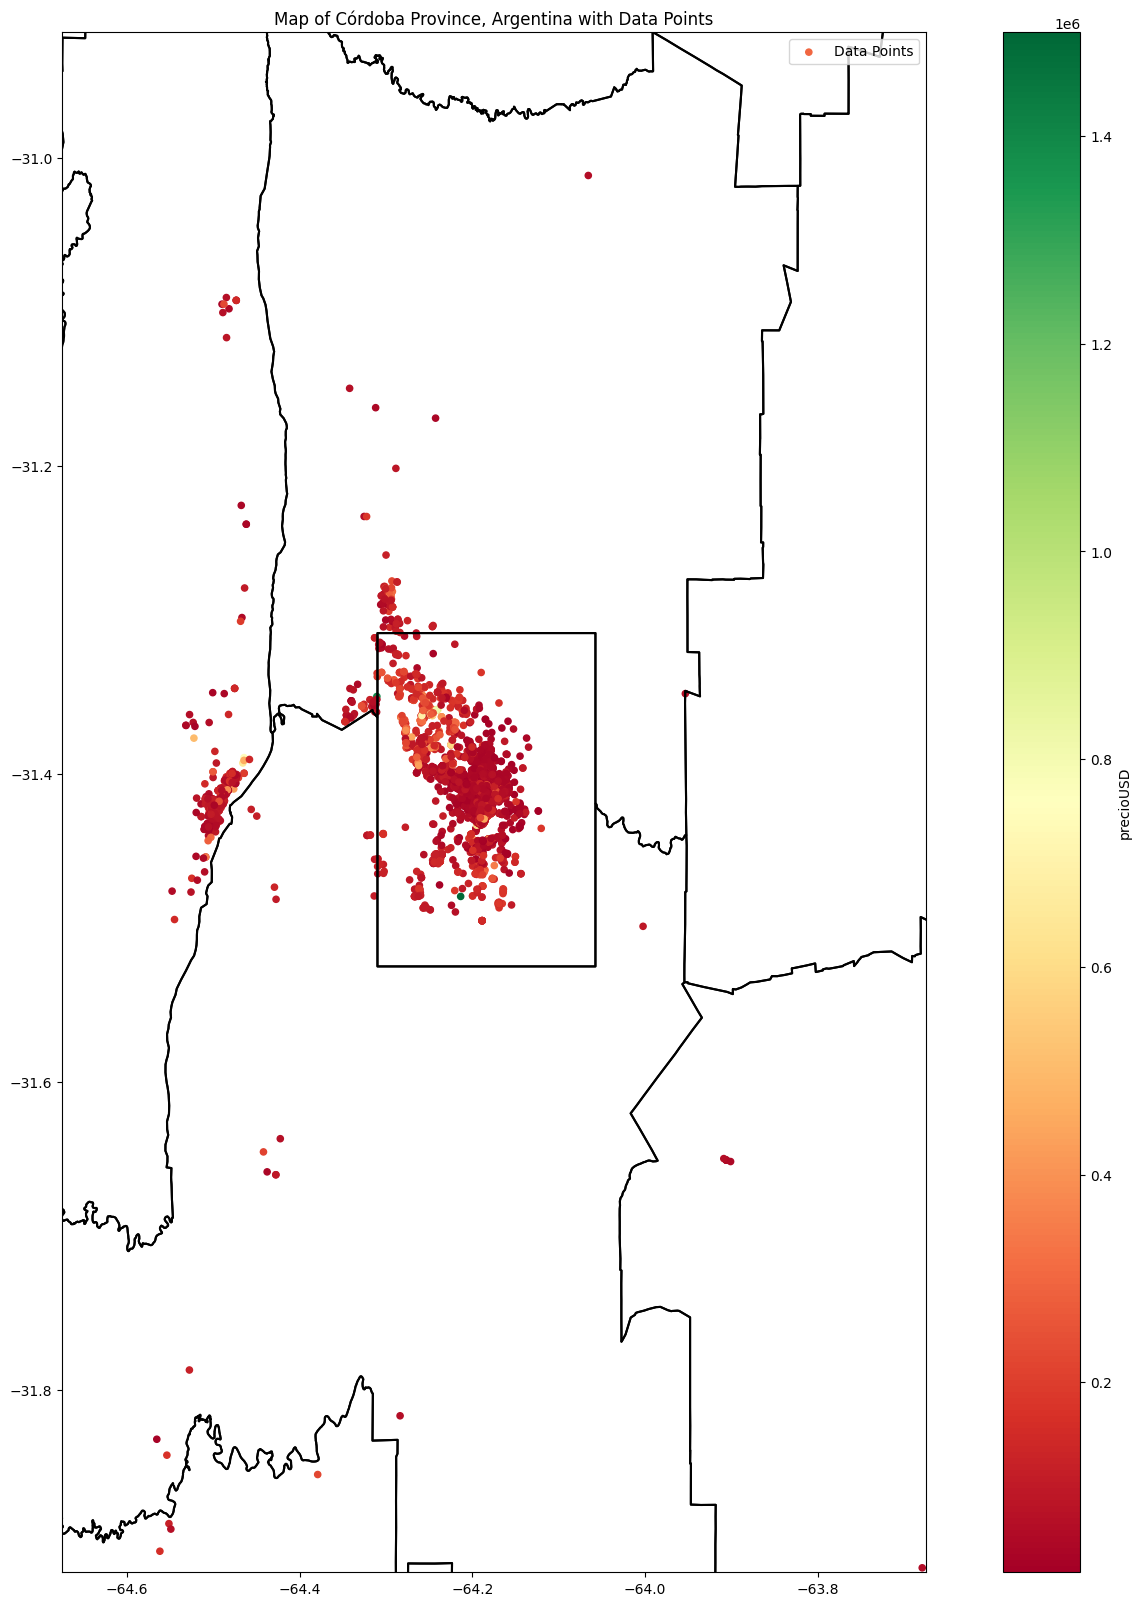

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'ubicados' and has columns 'coordX' (latitude), 'coordY' (longitude), and 'precioUSD'
# Replace these values with the actual column names from your DataFrame
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']
precioUSD = ubicados['precioUSD']

# Calculate the mean latitude and longitude to center the map
mean_latitude = latitudes.mean()
mean_longitude = longitudes.mean()

# Read the shapefile of Córdoba province
cordoba_shapefile = './utils/maps/departamento.shp'
cordoba_province = gpd.read_file(cordoba_shapefile)

# Create a plot with the province boundary and center the map on the mean position
fig, ax = plt.subplots(figsize=(20, 20))
cordoba_province.boundary.plot(ax=ax, color='black')

# Color the data points based on 'precioUSD'
sc = ax.scatter(longitudes, latitudes, c=precioUSD, cmap='RdYlGn', s=20, label='Data Points')

# Set the colorbar for 'precioUSD' values
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('precioUSD')

# Set the extent of the map to zoom out a bit around the mean position
map_padding = 0.5  # Increase the padding for more zoom-out effect
ax.set_xlim(mean_longitude - map_padding, mean_longitude + map_padding)
ax.set_ylim(mean_latitude - map_padding, mean_latitude + map_padding)

# Add a title and legend
ax.set_title('Map of Córdoba Province, Argentina with Data Points')
ax.legend()

# Show the plot
plt.show()
